In [1]:
from brian2 import *
%matplotlib notebook

In [2]:
def create_dataset(num = 1000, shape = [28, 28], classes = 2):
    X = np.zeros((num, shape[0], shape[1]))
    y = np.zeros(num)
    for i in np.arange(X.shape[0]):
        decision = np.random.randint(0, classes)
        y[i] = decision
        start_x = 0
        start_y = decision
        for j in np.arange(shape[0]):
            X[i][clip(start_x+j, 0, shape[0]-1)][start_y] = 1.0
    
    return X, y

In [3]:
data, y = create_dataset(10000, [3, 3], classes = 3)

<IPython.core.display.Javascript object>


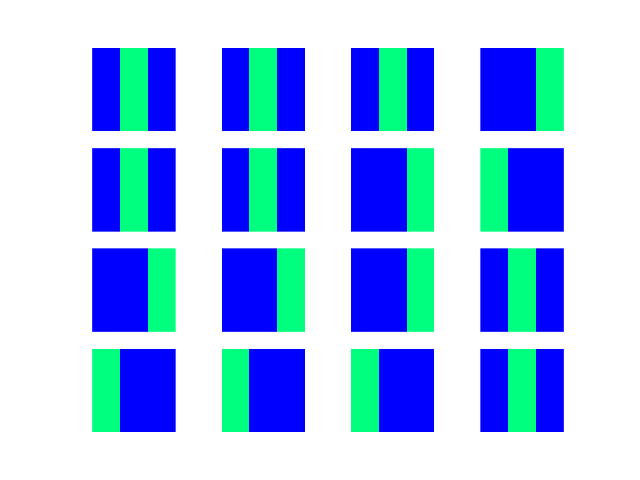

In [4]:
figure('data')
for j in np.arange(int(16)):
    subplot(4, 4, j+1)
    imshow(data[j].reshape(3, 3), cmap='winter', interpolation='None')
    axis('off')
show()

data = data.reshape(-1, 9)

In [87]:
start_scope()

n_input_width = 3.
n_input_height = n_input_width
n_input = n_input_width* n_input_height

n_hidden = 3

time_step = 0.1 * ms
alpha = 10 * ms
beta = 100 * ms
tau = 10*ms
tau_I = 15*ms
tau_h = 50*ms

wmax = 1.0
c_inp = 1.0
c_neg = 2.5
lr = 0.5
lr_n = 0.1
decay = 0.01

eqs_input_neuron = '''
rates : Hz
da/dt = -a/alpha : 1
dtheta/dt = -theta/beta : 1
diff = a - theta: 1
train : 1
'''

eqs_hidden_neuron = '''
dv/dt = (-v+I)/tau : 1 (unless refractory)
dI_inp/dt = -I_inp/tau_I :1
dI_neg/dt = -I_neg/tau_I :1
I_teacher : 1
I = I_inp + I_neg + I_teacher :1
da/dt = -a/alpha : 1
dtheta/dt = -theta/beta : 1
diff = a - theta: 1
dhold/dt = -hold/tau_h : 1
train : 1
'''

reset_hidden = '''
v = 0
hold += 0.1 * n_hidden
'''

eqs_input_syn = '''
w : 1
'''

# equations that describe changes if presynaptic spike of the forward-oriented synapse of input layer occures
eqs_input_pre = '''
I_inp_post += w * c_inp
a_pre += 1./n_hidden *1*ms/(alpha)
theta_pre += 1./n_hidden *1*ms/(beta)
'''

# equations that describe changes if postsynaptic spike of the forward synapse occures
eqs_input_post = '''
a_post += 1./n_input *1*ms/(alpha)
theta_post += 1./n_input *1*ms/(beta)
w = clip(w + train_pre * (-decay + lr*diff_pre), 0, wmax)
'''

eqs_neg_syn = '''
w : 1
'''

# equations that describe changes if presynaptic spike of the forward-oriented synapse of input layer occures
eqs_neg_pre = '''
I_neg_post += w * c_neg
'''

#w = clip(w + train_pre*(+decay - lr_n * diff_post), -wmax, 0)

# equations that describe changes if postsynaptic spike of the forward synapse occures
eqs_neg_post = '''
w = clip(w + train_pre*(-lr_n*diff_pre), -wmax, 0)
'''

In [89]:
P = NeuronGroup(n_input, eqs_input_neuron, threshold='rand()<rates*dt', method='linear', refractory=2*ms, dt = time_step, name='P')
P.rates = [k*250*Hz for k in data[0]]
P.train = np.ones_like(P.train)
P.a = np.random.rand(len(P))*0.5
P.theta = np.random.rand(len(P))*0.5

StateMonitorP = StateMonitor(P, ['rates', 'a', 'theta', 'diff'], record=True)

G = NeuronGroup(n_hidden, eqs_hidden_neuron, method='linear', threshold='v > hold', reset=reset_hidden, refractory=2*ms, dt=time_step, name = 'G')
G.train = np.ones_like(G.train)
G.a = np.random.rand(len(G))*0.5
G.theta = np.random.rand(len(G))*0.5     
G.hold = np.ones_like(G.hold) * 3.

StateMonitorG = StateMonitor(G, ['a', 'I', 'diff', 'I_inp', 'I_neg', 'hold'], record=True)

S = Synapses(P, G, eqs_input_syn, on_pre=eqs_input_pre, on_post=eqs_input_post, dt=time_step)
S.connect()
S.w = np.random.rand(len(S))

StateMonitorS = StateMonitor(S, ['w'], record=True)

S_neg = Synapses(G, G, eqs_neg_syn, on_pre=eqs_neg_pre, on_post=eqs_neg_post, dt=time_step)
S_neg.connect('i!=j')
#S_neg.w = np.random.rand(len(S_neg)) * (-1.)
S_neg.w = np.ones_like(S_neg.w) * (-1.)

StateMonitorS_neg = StateMonitor(S_neg, ['w'], record=True)

predictions = []
labels = []
counter = 0
train = 1
@network_operation(dt=50*ms)
def update_input():
    global counter
    global train
    if counter % 2 == 0:
        
        if counter:
            predictions.append(np.argmax(np.mean(StateMonitorG.a[:,-50:], axis=1)))
        
        index = np.random.randint(1,100)
        P.rates = [k*250*Hz for k in data[index]]
        if train:
            G.I_teacher = np.zeros_like(G.I_teacher)
            G.I_teacher[int(y[index])] = 10.

        labels.append(int(y[index]))
    else:
        P.rates = np.zeros_like(P.rates)
        G.I_teacher = np.zeros_like(G.I_teacher)
    counter += 1

run(10000*ms)

#add last prediction
predictions.append(np.argmax(np.mean(StateMonitorG.a[:,-50:], axis=1)))

In [90]:
from sklearn.metrics import accuracy_score

print accuracy_score(predictions, labels)

1.0


<IPython.core.display.Javascript object>


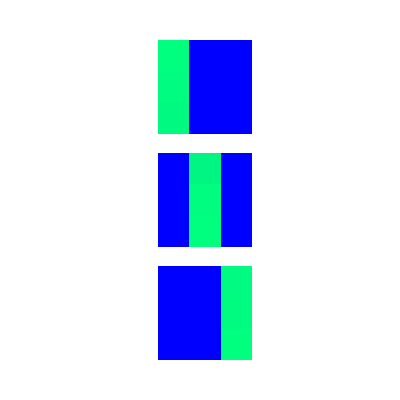

In [91]:
images_input = [[S.w[r + j * int(len(G))]
         for j in np.arange(len(P))] 
         for r in np.arange(len(G))]
images_input = np.array(images_input).reshape(int(n_hidden), int(n_input_width), int(n_input_height))


k=1
figure('input Weight visualisation', figsize=(5,5))
for image in images_input:
    subplot(3, 1, k)
    imshow(image, cmap='winter', interpolation='None')
    axis('off')

    k+=1

show()

<IPython.core.display.Javascript object>


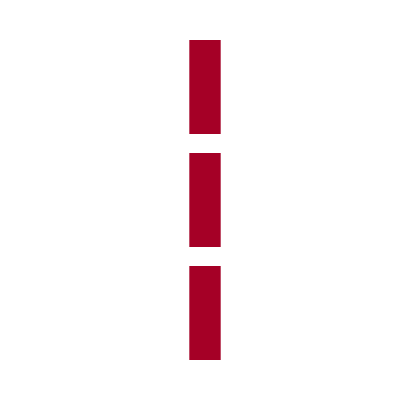

In [92]:
z = S_neg.w
for i in np.arange(int(len(G))):
    z = insert(z, i+int(len(G))*i, 0)
    
images_out_neg = np.array(z).reshape(int(len(G)), 1, 3)

k=1
figure('negative weight visualisation', figsize=(5,5))
for image in images_out_neg:
    subplot(3, 1, k)
    imshow(image.reshape(3,1), cmap='RdYlGn', interpolation='None')
    axis('off')
    
    k+=1

show()


<IPython.core.display.Javascript object>


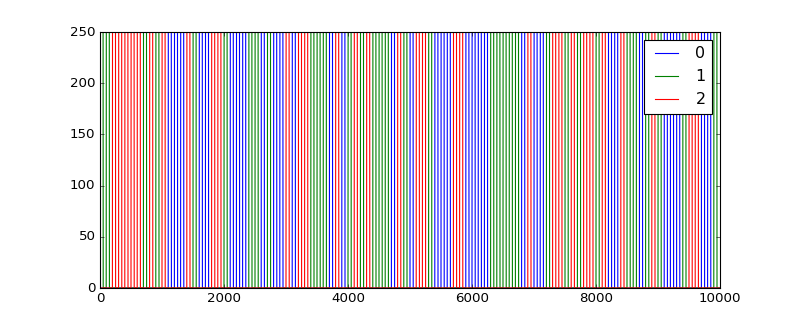

In [93]:
figure('P_rates', figsize=(10,4))
for k in np.arange(3):
    plot(StateMonitorP.t/ms, StateMonitorP.rates[k], linewidth=1, label = str(k))
legend(loc='best')
show()

#проверяем меняется ли вообще инпут (работает ли update_input)

<IPython.core.display.Javascript object>


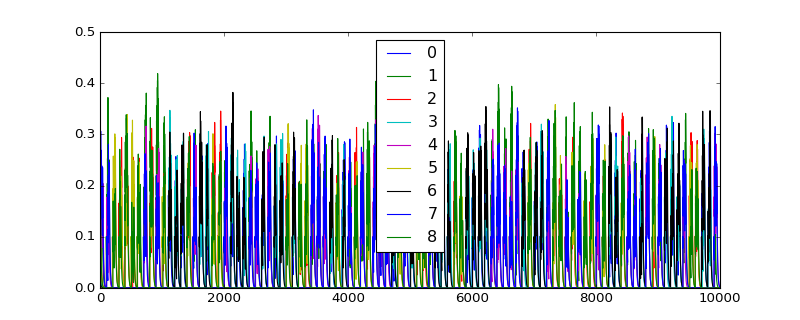

<IPython.core.display.Javascript object>


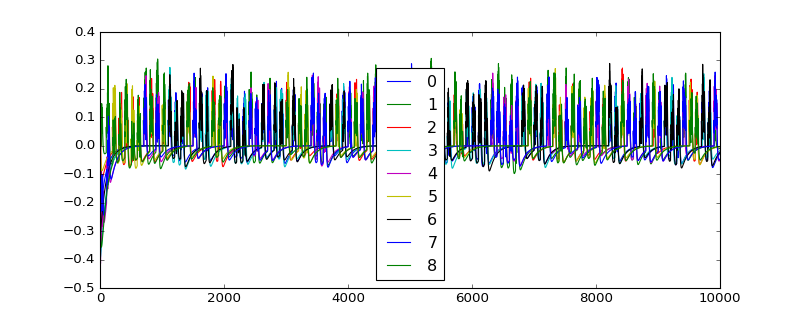

<IPython.core.display.Javascript object>


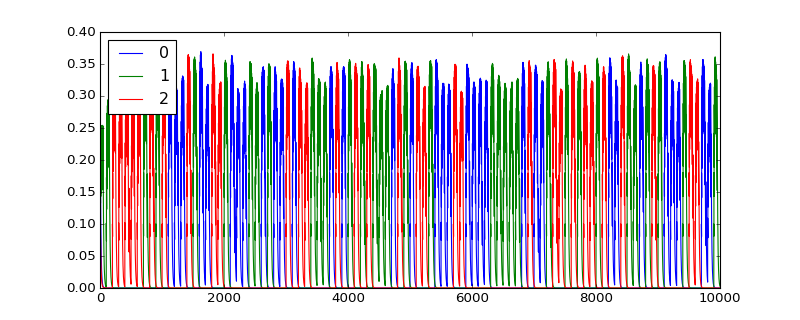

<IPython.core.display.Javascript object>


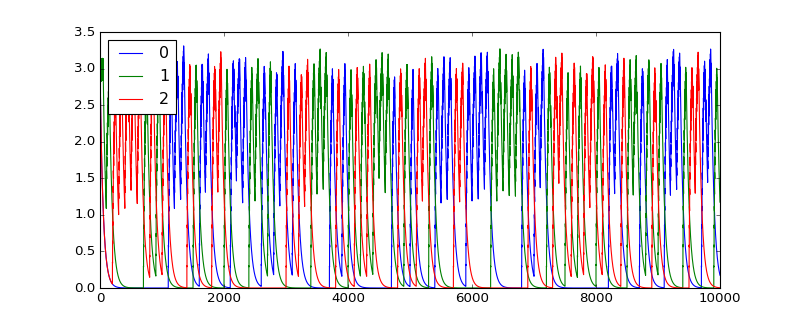

<IPython.core.display.Javascript object>


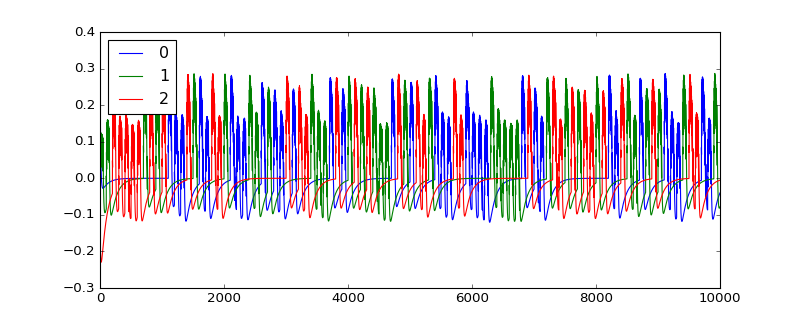

In [94]:
figure('P_a', figsize=(10,4))
for k in np.arange(len(P)):
    plot(StateMonitorP.t/ms, StateMonitorP.a[k], linewidth=1, label = str(k))
legend(loc='best')
show()

figure('P_ a-theta', figsize=(10,4))
for k in np.arange(len(P)):
    plot(StateMonitorP.t/ms, StateMonitorP.diff[k], linewidth=1, label = str(k))
legend(loc='best')
show()

figure('G_a', figsize=(10,4))
for k in np.arange(len(G)):
    plot(StateMonitorG.t/ms, StateMonitorG.a[k], linewidth=1, label = str(k))
legend(loc='best')
show()

figure('G_hold', figsize=(10,4))
for k in np.arange(len(G)):
    plot(StateMonitorG.t/ms, StateMonitorG.hold[k], linewidth=1, label = str(k))
legend(loc='best')
show()

figure('G_diff', figsize=(10,4))
for k in np.arange(len(G)):
    plot(StateMonitorG.t/ms, StateMonitorG.diff[k], linewidth=1, label = str(k))
legend(loc='best')
show()

#проверяем активность нейронов разных слоев (меняется ли она вообще?)

<IPython.core.display.Javascript object>


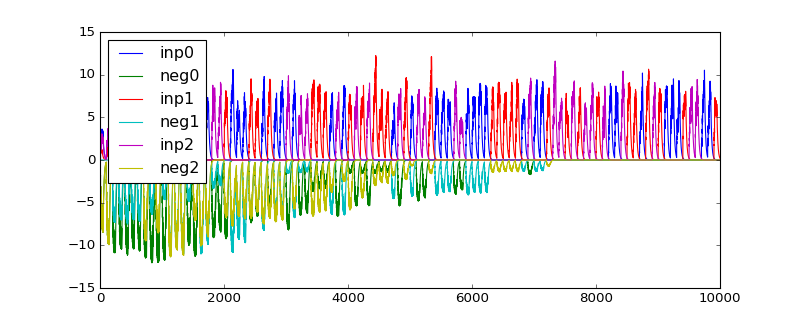

In [95]:
figure('G_I', figsize=(10,4))
for k in np.arange(len(G)):
    plot(StateMonitorG.t/ms, StateMonitorG.I_inp[k], linewidth=1, label = 'inp' + str(k))
    plot(StateMonitorG.t/ms, StateMonitorG.I_neg[k], linewidth=1, label = 'neg' + str(k))
legend(loc='best')
show()

<IPython.core.display.Javascript object>


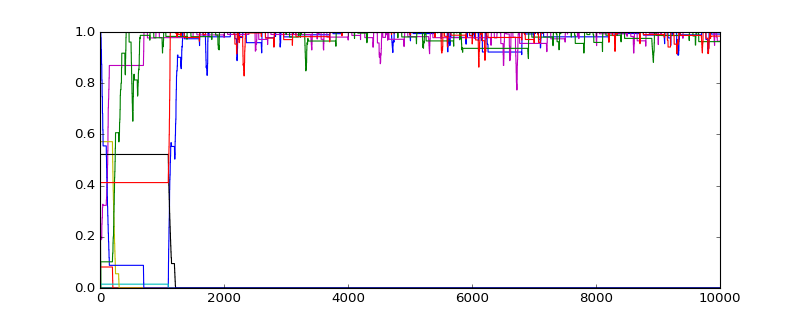

In [96]:
figure('input weights', figsize=(10,4))
for k in np.arange(10):
    plot(StateMonitorS.t/ms, StateMonitorS.w[k], linewidth=1, label = str(k))
#legend(loc='best')
show()

#проверяем есть ли какие-то аномалии в изменении весов нейронов

<IPython.core.display.Javascript object>


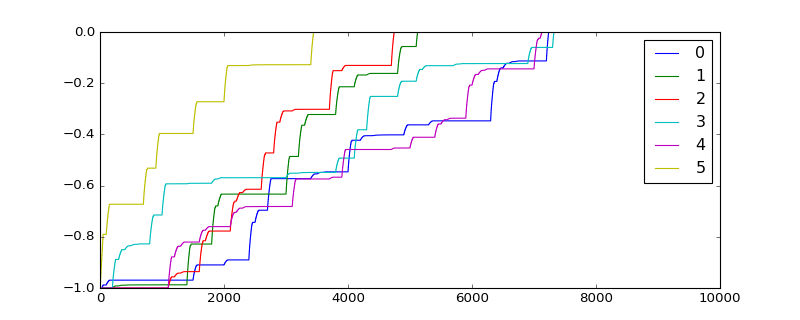

In [97]:
figure('negative intr weights', figsize=(10,4))
for k in np.arange(len(S_neg)):
    plot(StateMonitorS_neg.t/ms, StateMonitorS_neg.w[k], linewidth=1, label = str(k))
legend(loc='best')
show()

#проверяем есть ли какие-то аномалии в изменении весов нейронов

In [98]:
predictions = []
labels = []
counter = 0
train = 0

run(5000*ms)

#add last prediction
predictions.append(np.argmax(np.mean(StateMonitorG.a[:,-50:], axis=1)))

print accuracy_score(predictions, labels)

1.0


<IPython.core.display.Javascript object>


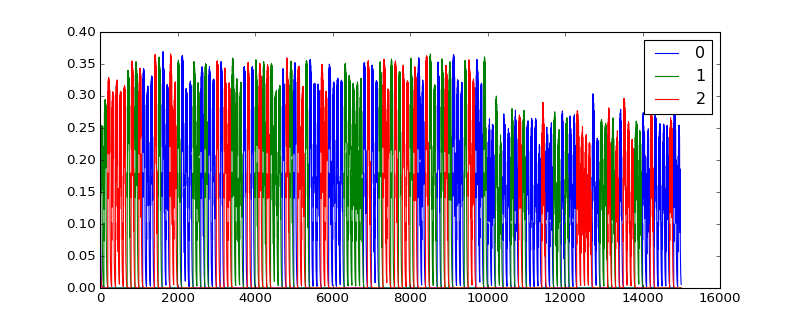

In [99]:
figure('G_a_test', figsize=(10,4))
for k in np.arange(len(G)):
    plot(StateMonitorG.t/ms, StateMonitorG.a[k], linewidth=1, label = str(k))
legend(loc='best')
show()

<IPython.core.display.Javascript object>


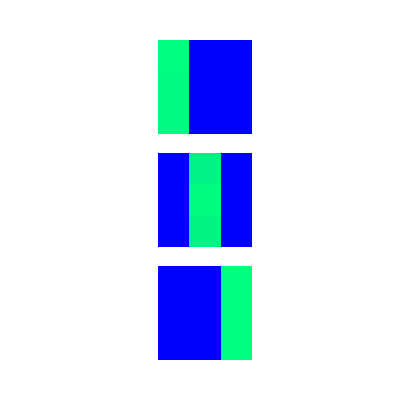

In [100]:
images_input = [[S.w[r + j * int(len(G))]
         for j in np.arange(len(P))] 
         for r in np.arange(len(G))]
images_input = np.array(images_input).reshape(int(n_hidden), int(n_input_width), int(n_input_height))


k=1
figure('input Weight visualisation test', figsize=(5,5))
for image in images_input:
    subplot(3, 1, k)
    imshow(image, cmap='winter', interpolation='None')
    axis('off')

    k+=1

show()